# Ensemble Learning

## Initial Imports

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [19]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [20]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [21]:
# Create our features
X = df.drop("loan_status", axis=1)

X = pd.get_dummies(X)

# Create our target
y = df["loan_status"]

In [22]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [23]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [24]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [25]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [26]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
x_scaler = scaler.fit(X_train)

In [27]:
# Scale the training and testing data
x_train_scaled = x_scaler.transform(X_train)
x_test_scaled = x_scaler.transform(X_test)
x_test_scaled

array([[-0.65213882,  0.06433861, -0.49975826, ..., -0.40374336,
         0.        ,  0.        ],
       [-0.62541809,  0.69918009, -0.80025534, ..., -0.40374336,
         0.        ,  0.        ],
       [ 2.26284965, -0.95016298,  2.68802733, ..., -0.40374336,
         0.        ,  0.        ],
       ...,
       [-0.16630741,  0.58092531, -0.4164621 , ..., -0.40374336,
         0.        ,  0.        ],
       [-1.07967046, -0.30287362, -1.03066301, ..., -0.40374336,
         0.        ,  0.        ],
       [ 2.26284965,  0.35271432,  3.10152711, ...,  2.47682094,
         0.        ,  0.        ]])

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [29]:
# Resample the training data with the BalancedRandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(x_train_scaled, y_train)

In [31]:
# Calculated the balanced accuracy score
y_pred = rf_model.predict(x_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.683080618047773

In [32]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   37,    64],
       [    3, 17101]])

In [33]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.93      0.37      1.00      0.52      0.61      0.34       101
   low_risk       1.00      1.00      0.37      1.00      0.61      0.39     17104

avg / total       1.00      1.00      0.37      1.00      0.61      0.39     17205



In [35]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.07127092775611105, 'last_pymnt_amnt'),
 (0.06637665031002372, 'total_rec_prncp'),
 (0.0645913897065272, 'total_rec_int'),
 (0.06133051775527748, 'total_pymnt'),
 (0.06065445452610138, 'total_pymnt_inv'),
 (0.02212586185954721, 'installment'),
 (0.021378399881717452, 'out_prncp'),
 (0.021084100129542174, 'out_prncp_inv'),
 (0.016371389750760225, 'dti'),
 (0.01572274876112443, 'max_bal_bc'),
 (0.01567031185735686, 'mo_sin_old_rev_tl_op'),
 (0.015264448790649072, 'loan_amnt'),
 (0.014881554424497567, 'mo_sin_old_il_acct'),
 (0.014312348867934343, 'total_bal_ex_mort'),
 (0.01424339653250497, 'tot_hi_cred_lim'),
 (0.014146604816062435, 'total_bal_il'),
 (0.014019446828585986, 'revol_bal'),
 (0.013773980596759399, 'tot_cur_bal'),
 (0.013717234286621431, 'bc_util'),
 (0.01349094662096283, 'avg_cur_bal'),
 (0.013480444341604685, 'total_bc_limit'),
 (0.01330298293045531, 'bc_open_to_buy'),
 (0.012773252985126568, 'total_rec_late_fee'),
 (0.012676410981875025, 'total_il_high_credit_limit'),


<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

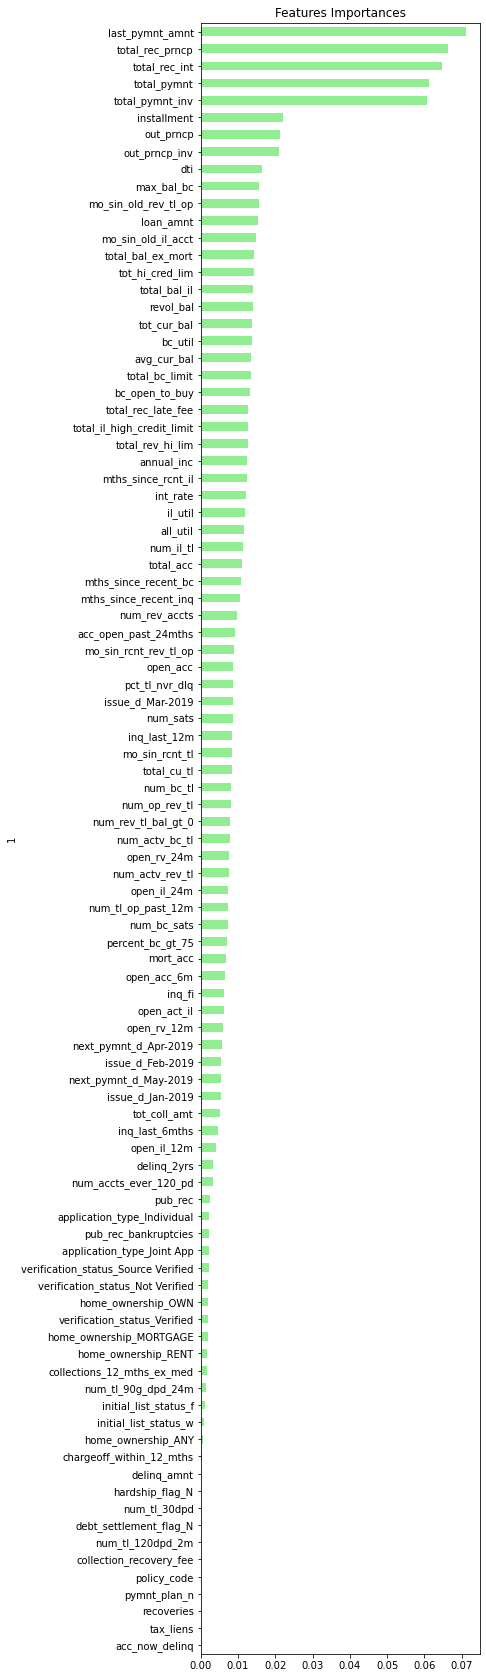

In [46]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', figsize=(5,30) , color='lightgreen', title= 'Features Importances', legend=False)


### Easy Ensemble Classifier

In [47]:
# Train the Classifier
from sklearn.ensemble import RandomForestClassifier
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, Y)

In [51]:
# Calculated the balanced accuracy score
y_pred = rf_model.predict(x_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.683080618047773

In [52]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   37,    64],
       [    3, 17101]])

In [53]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.93      0.37      1.00      0.52      0.61      0.34       101
   low_risk       1.00      1.00      0.37      1.00      0.61      0.39     17104

avg / total       1.00      1.00      0.37      1.00      0.61      0.39     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    They both have an accuracy score of 1.0

2. Which model had the best recall score?

    Both have a recall score of 1.0

3. Which model had the best geometric mean score?

    Both have a geometric mean score of .61

4. What are the top three features?

   Pre, Rec, and f1